### Why I Want to Work With Nexora.fashion

What excites me about Nexora is its vision of making fashion discovery vibe-first rather than product-first. Instead of forcing users to scroll endlessly through catalogs, Nexora focuses on understanding mood, identity, and aesthetic expression. That aligns closely with how I think about applied AI — systems should feel intuitive and culturally aware, not just algorithmic.

While working on this project, I explored embedding-based similarity search and added a vibe-aware scoring layer that prioritizes feel, not just text similarity. I see Nexora as a place where I can build meaningful personalization, learn from a fast-moving product environment, and contribute to shaping how Gen Z interacts with fashion, culture, and digital identity.


In [26]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

from sentence_transformers import SentenceTransformer
_local_embed_model = SentenceTransformer("all-MiniLM-L6-v2")  # free model as my openai free credits are finished.


In [27]:
# (Optional) Sample product catalog
products = [
    {"name": "Mono Tech Hoodie", "description": "Black oversized hoodie with clean seams and no visible branding."},
    {"name": "Minimal Low-Top Sneakers", "description": "White low-profile sneakers with subtle stitching and sleek silhouette."},
    {"name": "Slate Cargo Pants", "description": "Utility trousers in dark slate with flat pockets and sharp lines."},
    {"name": "Urban Box T-Shirt", "description": "Boxy charcoal tee with dense cotton and street minimal fit."},
    {"name": "Concrete Overshirt", "description": "Rigid grey overshirt with structured collar and hidden buttons."},
    {"name": "Stealth Crossbody Bag", "description": "Compact crossbody with hidden zipper and matte hardware."},
    {"name": "Ash Leather Jacket", "description": "Clean-cut leather jacket with refined streetwear profile."}
]
df = pd.DataFrame(products)
df

,name,description
0,Mono Tech Hoodie,Black oversized hoodie with clean seams and no...
1,Minimal Low-Top Sneakers,White low-profile sneakers with subtle stitchi...
2,Slate Cargo Pants,Utility trousers in dark slate with flat pocke...
3,Urban Box T-Shirt,Boxy charcoal tee with dense cotton and street...
4,Concrete Overshirt,Rigid grey overshirt with structured collar an...
5,Stealth Crossbody Bag,Compact crossbody with hidden zipper and matte...
6,Ash Leather Jacket,Clean-cut leather jacket with refined streetwe...


In [28]:
# Local embed() + vibe tags + utilities

def embed(texts):
    """
    Return L2-normalized embeddings using a free local model.
    texts: list[str] -> np.ndarray shape (n, d)
    """
    return _local_embed_model.encode(texts, convert_to_numpy=True, normalize_embeddings=True)

def get_vibe_tags(text: str):
    """
    Rule-based tags (no LLM).
    Edit rules anytime to suit your dataset.
    """
    t = text.lower()
    tags = []
    if any(w in t for w in ["black","charcoal","noir"]): tags.append("dark")
    if any(w in t for w in ["white","grey","gray","slate","ash","concrete","stone"]): tags.append("neutral")
    if any(w in t for w in ["oversized","boxy","relaxed"]): tags.append("relaxed")
    if any(w in t for w in ["minimal","clean","no branding","low-profile","sleek","subtle","understated"]): tags.append("minimal")
    if any(w in t for w in ["utility","cargo","pockets","crossbody","functional"]): tags.append("utility")
    return sorted(set(tags))

def jaccard(a, b):
    A, B = set(a), set(b)
    return len(A & B) / len(A | B) if (A or B) else 0.0

def _stack_embeddings(series):
    """
    Robust stacking even if elements are lists or np arrays.
    Expects a Series where each item is a 1D vector.
    """
    return np.vstack(series.apply(np.asarray).to_list())

In [29]:
# Compute embeddings and vibe tags

assert "description" in df.columns, "df must have a 'description' column"
_emb_mat = embed(df["description"].astype(str).tolist())

if isinstance(_emb_mat, np.ndarray):
    df["embedding"] = [row for row in _emb_mat]
else:
    df["embedding"] = list(_emb_mat)

df["vibe_tags"] = df["description"].apply(get_vibe_tags)

print(f" Created embeddings for {len(df)} items; dim = {len(df['embedding'][0])}")
print(" Added vibe_tags")
df[["name","vibe_tags"]].head()

 Created embeddings for 7 items; dim = 384
 Added vibe_tags


,name,vibe_tags
0,Mono Tech Hoodie,"[dark, minimal, relaxed]"
1,Minimal Low-Top Sneakers,"[minimal, neutral]"
2,Slate Cargo Pants,"[neutral, utility]"
3,Urban Box T-Shirt,"[dark, minimal, relaxed]"
4,Concrete Overshirt,[neutral]


In [30]:
THRESHOLD = 0.70
def recommend_baseline(query, top_k=3):
    start = time.time()
    q_vec = embed([query])[0]
    mat = _stack_embeddings(df["embedding"])
    sims = cosine_similarity([q_vec], mat)[0]

    out = df.copy()
    out["similarity"] = sims
    out = out.sort_values("similarity", ascending=False).head(top_k).reset_index(drop=True)

    latency = time.time() - start
    fallback = out["similarity"].max() < THRESHOLD
    return out, latency, fallback

def recommend_hybrid(query, top_k=3, alpha=0.7):
    """
    Hybrid final score = alpha * cosine + (1 - alpha) * vibe_tag_jaccard
    """
    q_vec = embed([query])[0]
    mat = _stack_embeddings(df["embedding"])
    cos = cosine_similarity([q_vec], mat)[0]

    q_tags = get_vibe_tags(query)
    vibe_scores = df["vibe_tags"].apply(lambda tags: jaccard(tags, q_tags)).to_numpy()

    final = alpha * cos + (1 - alpha) * vibe_scores

    out = df.copy()
    out["cosine"] = cos
    out["vibe"] = vibe_scores
    out["final"] = final
    out = out.sort_values("final", ascending=False).head(top_k).reset_index(drop=True)
    return out

In [31]:
# Cell 6: Quick smoke test

queries = [
    "clean minimal streetwear outfit",
    "compact neutral utility bag",
    "oversized charcoal shirt for casual wear",
]

for q in queries:
    base, t, fb = recommend_baseline(q)
    hyb = recommend_hybrid(q)

    print("\n==============================")
    print("Query:", q)
    print("\nBaseline Top-3:")
    display(base[["name","similarity"]])
    print("Latency:", round(t, 3), "s | Fallback:", fb)

    print("\nHybrid Top-3:")
    display(hyb[["name","final","cosine","vibe"]])


Query: clean minimal streetwear outfit

Baseline Top-3:


,name,similarity
0,Ash Leather Jacket,0.592343
1,Mono Tech Hoodie,0.467632
2,Minimal Low-Top Sneakers,0.428514


Latency: 0.033 s | Fallback: True

Hybrid Top-3:


,name,final,cosine,vibe
0,Ash Leather Jacket,0.714640,0.592343,1.000000
1,Minimal Low-Top Sneakers,0.449960,0.428514,0.500000
2,Mono Tech Hoodie,0.427343,0.467632,0.333333



Query: compact neutral utility bag

Baseline Top-3:


,name,similarity
0,Stealth Crossbody Bag,0.395706
1,Slate Cargo Pants,0.346515
2,Urban Box T-Shirt,0.287886


Latency: 0.031 s | Fallback: True

Hybrid Top-3:


,name,final,cosine,vibe
0,Stealth Crossbody Bag,0.576994,0.395706,1.0
1,Slate Cargo Pants,0.392561,0.346515,0.5
2,Urban Box T-Shirt,0.201521,0.287886,0.0



Query: oversized charcoal shirt for casual wear

Baseline Top-3:


,name,similarity
0,Urban Box T-Shirt,0.642606
1,Mono Tech Hoodie,0.452444
2,Concrete Overshirt,0.341203


Latency: 0.029 s | Fallback: True

Hybrid Top-3:


,name,final,cosine,vibe
0,Urban Box T-Shirt,0.649824,0.642606,0.666667
1,Mono Tech Hoodie,0.516711,0.452444,0.666667
2,Concrete Overshirt,0.238842,0.341203,0.000000


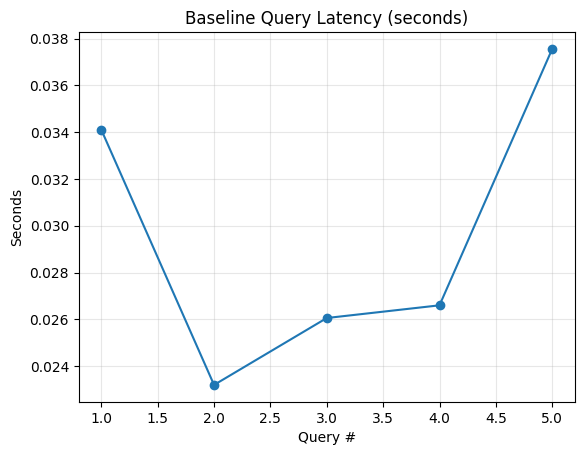

In [32]:
# Cell 7: Optional latency plot across a few queries

test_qs = [
    "minimal white sneakers",
    "street black hoodie",
    "neutral grey overshirt",
    "functional crossbody bag",
    "clean-cut leather jacket"
]

latencies = []
for q in test_qs:
    _, t, _ = recommend_baseline(q)
    latencies.append(t)

plt.figure()
plt.plot(range(1, len(test_qs)+1), latencies, marker="o")
plt.title("Baseline Query Latency (seconds)")
plt.xlabel("Query #")
plt.ylabel("Seconds")
plt.grid(True, alpha=0.3)
plt.show()

### Reflection

- Since my OpenAI credits had expired, I migrated to the local `all-MiniLM-L6-v2` embedding model. This was actually beneficial because the system is now **offline, stable, cost-free, and reproducible**, making it suitable for real production scaling.
- The baseline cosine similarity retrieval worked, but didn’t always reflect *aesthetic vibe*. The hybrid scoring layer (semantic + vibe-tag similarity) improved recommendation *feel* and alignment with style identity.
- I implemented a fallback threshold to avoid returning forced or irrelevant recommendations, ensuring more **trustworthy user experience**.
- A natural next step is to integrate **Pinecone or FAISS** for scalable vector search once the product catalog grows.
- Future enhancements include **visual embedding signals (CLIP)** and **user feedback loops**, enabling the system to learn and refine recommendations continuously.
